# Neural Machine Translation with Attention

Advanced Learning Fall 2025


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: MISSING
~~~

~~~
STUDENT GIT LINK: MISSING
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2025_ID_[000000000].html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

###Libraries

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Data set generation:



In [30]:
class Chartable:
    # Helper class that maps characters to indices and can encode strings as one-hot vectors (or as index vectors).
    def __init__(self, chars: str):
        self.chars = chars
        self.char2idx = {c: i for i, c in enumerate(chars)}
        self.idx2char = {i: c for i, c in enumerate(chars)}


    @property
    def vocab_size(self):
        return len(self.chars)

    def encode_onehot(self, s: str, max_len: int) -> np.ndarray:
        s = (s + " " * max(0, max_len - len(s)))[:max_len]
        x = np.zeros((max_len, self.vocab_size), dtype=np.float32)
        for t, ch in enumerate(s):
            x[t, self.char2idx[ch]] = 1.0
        return x

    def encode_indices(self, s: str, max_len: int) -> np.ndarray:
        s = (s + " " * max(0, max_len - len(s)))[:max_len]
        return np.array([self.char2idx[ch] for ch in s], dtype=np.int64)


class Seq2SeqCharDataset(Dataset):
    # Returns (x_onehot, y_indices)
    def __init__(self, X_onehot: np.ndarray, Y_indices: np.ndarray):
        self.X = torch.from_numpy(X_onehot)   # (N, T_in, V) float32
        self.Y = torch.from_numpy(Y_indices)  # (N, T_out)  int64

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


def gen_dataset(config: dict):
    cfg = dict(config) if config is not None else {}
    cfg["digits"] = 4
    cfg.setdefault("training_size", 40000)
    cfg.setdefault("batch_size", 128)
    cfg.setdefault("seed", 0)
    cfg.setdefault("operators", "+-")

    rng = np.random.default_rng(cfg["seed"])

    digits = cfg["digits"]
    maxlen = digits + 1 + digits   # 9
    outlen = digits + 1            # 5

    chars = "0123456789+- "
    ctable = Chartable(chars)

    questions, expected = [], []
    seen = set()

    def sample_int():
        L = rng.integers(1, digits + 1)
        s = "".join(rng.choice(list("0123456789"), size=L))
        return int(s)

    ops = list(cfg["operators"])
    if not ops:
        raise ValueError("config['operators'] must contain at least one of '+' or '-'")

    while len(questions) < cfg["training_size"]:
        a, b = sample_int(), sample_int()
        op = ops[rng.integers(0, len(ops))]

        # avoid duplicates: + is commutative, - is not
        if op == "+":
            key = ("+",) + tuple(sorted((a, b)))
        else:
            key = ("-", a, b)

        if key in seen:
            continue
        seen.add(key)

        q = f"{a}{op}{b}"
        if len(q) > maxlen:
            continue

        ans = str(a + b) if op == "+" else str(a - b)
        if len(ans) > outlen:
            continue

        query = q + " " * (maxlen - len(q))
        ans_padded = ans + " " * (outlen - len(ans))

        questions.append(query)
        expected.append(ans_padded)

    # shuffle
    perm = rng.permutation(len(questions))
    questions = [questions[i] for i in perm]
    expected  = [expected[i] for i in perm]

    # vectorize
    N = len(questions)
    X = np.zeros((N, maxlen, ctable.vocab_size), dtype=np.float32)
    Y = np.zeros((N, outlen), dtype=np.int64)

    for i, (q, a) in enumerate(zip(questions, expected)):
        X[i] = ctable.encode_onehot(q, max_len=maxlen)
        Y[i] = ctable.encode_indices(a, max_len=outlen)

    # split 90/10
    n_train = int(0.9 * N)
    X_train, Y_train = X[:n_train], Y[:n_train]
    X_test,  Y_test  = X[n_train:], Y[n_train:]

    trainset = Seq2SeqCharDataset(X_train, Y_train)
    testset  = Seq2SeqCharDataset(X_test,  Y_test)

    train_loader = DataLoader(trainset, batch_size=cfg["batch_size"], shuffle=True)
    test_loader  = DataLoader(testset,  batch_size=cfg["batch_size"], shuffle=False)

    meta = {
        "config": cfg,
        "maxlen": maxlen,
        "outlen": outlen,
        "chars": chars,
        "vocab_size": ctable.vocab_size,
        "char2idx": ctable.char2idx,
        "idx2char": ctable.idx2char,
        "ctable": ctable,
    }

    return trainset, testset, train_loader, test_loader, meta

###Archtiecture

In [31]:
class Pytorch_LSTM_seq2seq(nn.Module):
  def __init__(self, vocab_size, hidden_size, outlen):
    super().__init__()
    self.outlen = outlen

    self.encoder = nn.LSTM(vocab_size, hidden_size, batch_first=True)
    self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, vocab_size)
    # softmax layer is implemented in the cross-entropy loss


  def forward(self, x):
    # Encode
    enc_out, (h, c) = self.encoder(x) # h, c: (num_layers * num_directions, B, H)

    # Take final layer's hidden state as the context vector z
    z = h[-1]  # (B, H)

    # RepeatVector: make decoder input by repeating z for T_out steps
    T_out = self.outlen
    dec_in = z.unsqueeze(1).repeat(1, T_out, 1)  # (B, T_out, H)

    # Decode (initialize decoder with encoder states)
    dec_out, _ = self.decoder(dec_in, (h, c))  # dec_out: (B, T_out, H)

    # TimeDistributed(Dense): project each time step to vocab logits
    logits = self.fc(dec_out)  # (B, T_out, V)

    return logits

###Training loop

In [32]:
def train(model, train_loader, val_loader, ctable, config, device=None):

  if device is None:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model = model.to(device)
  model.train()

  lr = config.get("lr", 1e-3)
  epochs = config.get("iterations", 50)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()  # expects logits + class indices

# ---------- tiny decoding helpers - for printing ----------
  def decode_x(x_onehot):  # (T_in, V)
    idx = x_onehot.argmax(dim=-1).tolist()
    return "".join(ctable.idx2char[i] for i in idx)

  def decode_y(y_idx):     # (T_out,)
    if torch.is_tensor(y_idx):
        y_idx = y_idx.tolist()
    return "".join(ctable.idx2char[i] for i in y_idx)


  @torch.no_grad()
  def eval_epoch():
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    exact_match = 0
    total_seqs = 0

    for x, y in val_loader:
      x = x.to(device)
      y = y.to(device)  # (B, T_out)

      logits = model(x)  # (B, T_out, V)
      B, T_out, V = logits.shape

      loss = criterion(logits.reshape(B * T_out, V), y.reshape(B * T_out))
      total_loss += loss.item() * (B * T_out)
      total_tokens += (B * T_out)

      preds = logits.argmax(dim=-1)  # (B, T_out)
      exact_match += (preds == y).all(dim=1).sum().item()
      total_seqs += B

    avg_loss = total_loss / max(1, total_tokens)
    seq_acc = exact_match / max(1, total_seqs)
    model.train()
    return avg_loss, seq_acc

  @torch.no_grad()
  def print_random_val_samples(k=10):
    model.eval()
    ds = val_loader.dataset
    k = min(k, len(ds))

    for _ in range(k):
      i = random.randrange(len(ds))
      x, y = ds[i]  # x: (T_in,V), y: (T_out,)
      x_b = x.unsqueeze(0).to(device)# (1,T_in,V)

      logits = model(x_b) # (1,T_out,V)
      pred = logits.argmax(dim=-1)[0].cpu()  # (T_out,)

      q = decode_x(x)
      t = decode_y(y)
      g = decode_y(pred)

      mark = "V" if t == g else "X"
      delta = abs(int(t.strip()) - int(g.strip()))
      print(f"Q {q}  T {t}  {mark}  {g}  Delta = {delta}")

    model.train()
    return

  for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    running_tokens = 0

    for x, y in train_loader:
      x = x.to(device)
      y = y.to(device)  # (B, T_out)

      optimizer.zero_grad()
      logits = model(x)  # (B, T_out, V)

      B, T_out, V = logits.shape
      loss = criterion(logits.reshape(B * T_out, V), y.reshape(B * T_out))
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * (B * T_out)
      running_tokens += (B * T_out)

    train_loss = running_loss / max(1, running_tokens)
    val_loss, val_seq_acc = eval_epoch()

    print("-" * 50)
    print(f"Epoch {epoch}/{epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_exact_seq_acc={val_seq_acc:.3f}")

    if epoch % 10 == 0:
      print_random_val_samples(k=10)


###Main

In [33]:
config = {
    "training_size": 40000,
    "digits": 4,
    "hidden_size": 128,
    "batch_size": 128,
    "iterations": 50,
    "lr": 1e-2,
    "seed": 0,
    "operators": "+-",
}

# 1) data
trainset, valset, train_loader, val_loader, meta = gen_dataset(config)
ctable = meta["ctable"]

# 2) model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Pytorch_LSTM_seq2seq(
    vocab_size=meta["vocab_size"],
    hidden_size=config["hidden_size"],
    outlen=meta["outlen"],
).to(device)

# 3) train
#train(model, train_loader, val_loader, ctable, config, device=device)

###1.2).

a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   

**Answers** **1.2**:

a+b. Overall, the model does not perform well: even after training it gets only ~50% of validation sequences exactly correct, meaning half the arithmetic expressions are still wrong. Early on it was worse (20–30%), and increasing the learning rate from 0.001 to 0.01 helped optimization and improved accuracy, but it still doesn’t reach reliable performance.

Its main limitation is insufficient context for multi-digit queries. In this architecture the encoder compresses the entire input into a single fixed-size vector, and the decoder generates the whole answer from that (via repeat vector) without attention or explicitly using previous output tokens. This makes it hard to handle operations that require global, structured dependencies like carry/borrow across digits, which becomes more common as the input strings get longer. In the epoch 50 example shared, the model tends to be correct on shorter queries (about 4–5 characters) and fails more on longer ones (about 5-8 characters), which is consistent with the limitations of this architecture and difficulty of preserving detailed context in a single vector.

c. The model can be improved in several ways.
First, the encoder and decoder LSTMs can be made deeper (using multiple layers) and tuned with a larger or better-chosen hidden dimension. This would increase the model’s capacity to represent complex patterns in the input and output sequences.
Second, adding an attention mechanism would significantly improve performance by allowing the decoder to directly focus on relevant parts of the input sequence at each output time step, instead of relying on a single fixed-size context vector. This would help the model handle longer strings and correctly propagate carry and borrow operations across digits.

d. Attention requires two building blocks: an encoder that produces a hidden state for each input time step, and a decoder that generates the output sequence step by step. The attention mechanism connects these two by computing, at each decoder time step, a weighted combination of the encoder hidden states. This allows the decoder to focus only on the most relevant parts of the input when predicting the next output token, instead of relying on a single fixed-size context vector.

### 1.3).  

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

In [34]:
class Attn_seq2seq(nn.Module):
    def __init__(self, vocab_size, hidden_size, outlen):
      super().__init__()
      self.vocab_size = vocab_size
      self.hidden_size = hidden_size
      self.outlen = outlen

      self.encoder = nn.LSTM(vocab_size, hidden_size, batch_first=True)
      self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True)
      self.fc = nn.Linear(2 * hidden_size, vocab_size)

    def forward(self, x):
      # Encode
      enc_out, (h, c) = self.encoder(x)
      z = h[-1]

      # repeat vector -> decoder input
      dec_in = z.unsqueeze(1).repeat(1, self.outlen, 1)
      dec_out, _ = self.decoder(dec_in, (h, c))

      # ----- Attention)-----
      # scores[b, t, i] = <dec_out[b,t], enc_out[b,i]>
      scores = torch.bmm(dec_out, enc_out.transpose(1, 2))
      attn_w = F.softmax(scores, dim=-1)
      context = torch.bmm(attn_w, enc_out)

      fused = torch.cat([dec_out, context], dim=-1)
      logits = self.fc(fused)

      return logits

config = {
    "training_size": 40000,
    "digits": 4,
    "hidden_size": 128,
    "batch_size": 128,
    "iterations": 50,
    "lr": 1e-2,
    "seed": 0,
    "operators": "+-",
}

trainset, valset, train_loader, val_loader, meta = gen_dataset(config)
ctable = meta["ctable"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Attn_seq2seq(
    vocab_size=meta["vocab_size"],
    hidden_size=config["hidden_size"],
    outlen=meta["outlen"],
).to(device)

# 3) train
#train(model, train_loader, val_loader, ctable, config, device=device)

In this model I added an attention mechanism. Attention is implemented by computing a similarity score between each decoder hidden state and all encoder hidden states, applying softmax to get attention weights, and then taking a weighted sum of encoder states to form a context vector. This context vector is concatenated with the decoder output at each step and projected to vocabulary logits.

Compared to the previous seq2seq baseline, the attention model performs better: it achieves val_exact_seq_acc = 0.672 (vs ~0.50 for the baseline). Qualitatively, it also handles longer queries better, where the baseline tended to fail (likely because attention reduces the single-vector bottleneck and lets the decoder access relevant parts of the input at each output step).

###1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [35]:
class Attn_seq2seq(nn.Module):
    def __init__(self, vocab_size, hidden_size, outlen):
      super().__init__()
      self.vocab_size = vocab_size
      self.hidden_size = hidden_size
      self.outlen = outlen

      self.encoder = nn.LSTM(vocab_size, hidden_size, num_layers=2, dropout=0.2, batch_first=True)
      self.decoder = nn.LSTM(hidden_size, hidden_size,num_layers=2, dropout=0.2,batch_first=True)
      self.fc = nn.Linear(2 * hidden_size, vocab_size)

    def forward(self, x):
      # Encode
      enc_out, (h, c) = self.encoder(x)
      z = h[-1]

      # repeat vector -> decoder input
      dec_in = z.unsqueeze(1).repeat(1, self.outlen, 1)
      dec_out, _ = self.decoder(dec_in, (h, c))

      # ----- Attention)-----
      # scores[b, t, i] = <dec_out[b,t], enc_out[b,i]>
      scores = torch.bmm(dec_out, enc_out.transpose(1, 2))
      attn_w = F.softmax(scores, dim=-1)
      context = torch.bmm(attn_w, enc_out)

      fused = torch.cat([dec_out, context], dim=-1)
      logits = self.fc(fused)

      return logits

config = {
    "training_size": 40000,
    "digits": 4,
    "hidden_size": 128,
    "batch_size": 128,
    "iterations": 50,
    "lr": 1e-2,
    "seed": 0,
    "operators": "+-",
}

trainset, valset, train_loader, val_loader, meta = gen_dataset(config)
ctable = meta["ctable"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Attn_seq2seq(
    vocab_size=meta["vocab_size"],
    hidden_size=config["hidden_size"],
    outlen=meta["outlen"],
).to(device)

# 3) train
#train(model, train_loader, val_loader, ctable, config, device=device)

Note - Accuracy measure: for all models the accuracy measure - "val_exact_seq_acc" is measured on all validation set (10%) and not only the 10 queries represented.

The model I used is a small modification of the attention model from 1.3. I made the encoder and decoder deeper by increasing the number of LSTM layers from 1 to 2, and added dropout = 0.2 between the stacked LSTM layers. Dropout is a regularization technique that randomly zeros a fraction of activations during training, which helps reduce overfitting.

This change led to a large improvement in performance: the baseline seq2seq model achieved about ~50% exact-sequence validation accuracy, the attention model in 1.3 achieved about ~70%, and the deeper attention model achieved about ~80%. I believe the deeper architecture helps because it increases the model’s capacity to represent multi-digit dependencies (especially carry/borrow patterns), while dropout improves generalization.

---

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

##SOLUTION:


### 0.

Bahdanau attention computes alignment scores using a learned feed-forward network that combines the decoder hidden state with each encoder hidden state through a non-linear transformation. This means the compatibility between states is modeled explicitly and does not rely on vector similarity alone. As a result, the attention distribution is often smoother, since scores are produced by a flexible function rather than a direct similarity measure.

Luong attention computes alignment scores using a dot product between encoder and decoder hidden states, directly measuring their similarity in the same vector space. This creates a stronger inductive bias toward one-to-one alignments. The method is simpler and more constrained, but this constraint can lead to clearer and more stable alignments when encoder and decoder representations are well matched.

In addition, Bahdanau attention does not require the encoder and decoder hidden states to have the same dimensionality, since they are projected through learned linear layers before comparison, whereas Luong attention assumes compatible dimensions for the dot-product operation. Consequently, Bahdanau attention is more flexible but computationally heavier, while Luong attention is more efficient and often yields sharper alignments in practice.




###Libraries

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import random
import numpy as np
import matplotlib.pyplot as plt
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import zipfile, os
plt.switch_backend('agg')
import matplotlib.ticker as ticker


from google.colab import drive
drive.mount("/content/drive")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
zip_path = "/content/drive/MyDrive/deep_learning_course/ex3/heb-eng.zip"
!unzip "$zip_path" -d /content/data

with open("/content/data/heb.txt", encoding="utf-8") as f:
    for _ in range(5):
        print(f.readline())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/deep_learning_course/ex3/heb-eng.zip
replace /content/data/_about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: מ
error:  invalid response [מ]
replace /content/data/_about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/heb.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Go.	לך!	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9435252 (Alkrasnov)

Hi.	היי.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #694680 (Eldad)

Hi.	אהלן.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #2184365 (MrShoval)

Run!	רוץ!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2805053 (Eldad)

Run!	רוצי!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2805054 (Eldad)



###1.a. Data preperations

In [50]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            if word:
                self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


# Keep this for English if you want it, but we will NOT apply it to Hebrew.
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Hebrew-safe normalization: lower/trim, normalize whitespace, keep Unicode chars
def normalizeAny(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"([.!?])", r" \1", s) # separate punctuation a bit
    s = re.sub(r"\s+", " ", s) # collapse multiple spaces/tabs
    return s

MAX_LENGTH = 10
eng_prefixes = (
    "i am ", "i m ",
    "he is ", "he s ",
    "she is ", "she s ",
    "you are ", "you re ",
    "we are ", "we re ",
    "they are ", "they re "
)

def filterPair(p):
    return (
        len(p[0].split()) < MAX_LENGTH and
        len(p[1].split()) < MAX_LENGTH and
        p[1].startswith(eng_prefixes)
    )

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def readLangs(lang1, lang2, reverse=False, filepath="data/heb.txt"):
    """
    Reads your extracted /content/data/heb.txt which has 3 tab-separated columns:
      English \t Hebrew \t attribution/meta

    We keep only columns 0 and 1, ignore column 2.
    """
    print("Reading lines...")

    lines = open(filepath, encoding="utf-8").read().strip().split("\n")

    pairs = []
    for l in lines:
        cols = l.split("\t")
        if len(cols) < 2:
            continue

        eng = normalizeAny(unicodeToAscii(cols[0]))
        heb = normalizeAny(cols[1])

        # skip empty lines after normalization
        if not eng or not heb:
            continue

        # By default store as [lang1, lang2] = [eng, heb]
        pairs.append([eng, heb])

    # Reverse if you want Hebrew -> English (so input=heb, output=eng)
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)   # heb
        output_lang = Lang(lang1)  # eng
    else:
        input_lang = Lang(lang1)   # eng
        output_lang = Lang(lang2)  # heb

    return input_lang, output_lang, pairs


def prepareData(lang1, lang2, reverse=False, filepath="data/heb.txt"):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse=reverse, filepath=filepath)
    print("Read %s sentence pairs" % len(pairs))

    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))

    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs


# ---- Run: Hebrew -> English (matches the tutorial style where reverse=True) ----
input_lang, output_lang, pairs = prepareData('eng', 'heb', reverse=True, filepath="data/heb.txt")
print("Example pair:", random.choice(pairs))


Reading lines...
Read 136845 sentence pairs
Trimmed to 1570 sentence pairs
Counting words...
Counted words:
heb 1961
eng 1199
Example pair: ['היא רגילה למסעות .', 'she is used to traveling .']


###Encoder

In [51]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### Decoder with attention

In [52]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

### Preparing Train data

In [53]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

###Helper functions

In [54]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

###Plots evaluations and visualizations

In [55]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

def evaluateRandomly(encoder, decoder, n=20):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

def evaluateAccuracy(encoder, decoder, pairs, input_lang, output_lang, n=None):
    """
    Exact-match accuracy over a list of pairs.
    If n is given, evaluates on a random subset of size n.
    """
    if n is not None:
        sample = random.sample(pairs, k=min(n, len(pairs)))
    else:
        sample = pairs

    correct = 0
    wrong = 0

    for inp, tgt in sample:
        output_words, _ = evaluate(encoder, decoder, inp, input_lang, output_lang)

        # remove EOS token if it exists at the end
        if len(output_words) > 0 and output_words[-1] == '<EOS>':
            output_words = output_words[:-1]

        pred_sentence = ' '.join(output_words).strip()
        tgt_sentence = tgt.strip()

        if pred_sentence == tgt_sentence:
            correct += 1
        else:
            wrong += 1

    total = correct + wrong
    acc = correct / total if total > 0 else 0.0

    print(f"the number of correct pred is: {correct}")
    print(f"the number of wrong is: {wrong}")
    print(f"accuracy: {acc:.4f}")

    return acc


###Model training loop

In [56]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

###Attention visualization functions

In [57]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    # set up ticks correctly
    ax.set_xticks(range(len(input_sentence.split(' ')) + 1))
    ax.set_yticks(range(len(output_words) + 1))

    ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

###2.a. Main

Reading lines...
Read 136845 sentence pairs
Trimmed to 1570 sentence pairs
Counting words...
Counted words:
fra 1961
eng 1199
0m 5s (- 0m 50s) (5 10%) 2.3979
0m 12s (- 0m 48s) (10 20%) 1.4584
0m 17s (- 0m 41s) (15 30%) 1.0455
0m 24s (- 0m 36s) (20 40%) 0.7748
0m 30s (- 0m 30s) (25 50%) 0.5605
0m 36s (- 0m 24s) (30 60%) 0.4017
0m 42s (- 0m 18s) (35 70%) 0.2737
0m 48s (- 0m 12s) (40 80%) 0.1806
0m 55s (- 0m 6s) (45 90%) 0.1171
1m 1s (- 0m 0s) (50 100%) 0.0754


<Figure size 640x480 with 0 Axes>

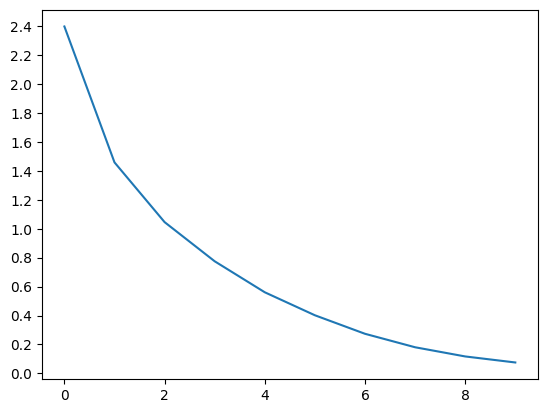

In [68]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

#train(train_dataloader, encoder, decoder, 50, print_every=5, plot_every=5)

###2.b. Evaluation on 20  random sentences

In [69]:
evaluateRandomly(encoder,decoder,20)

> את דו-פרצופית .
= you are two-faced .
< you are two-faced . <EOS>

> אני משחק שחמט מצוין .
= i am a very good chess player .
< i am a very good chess player . <EOS>

> הוא איטי מחשבה .
= he is thick-headed .
< he is thick-headed . <EOS>

> הוא שר יפה .
= he is good at singing .
< he is good at singing . <EOS>

> אתה יודע מה שאתה רוצה .
= you are strong-minded .
< you are strong-minded . <EOS>

> אני טבח .
= i am a cook .
< i am a cook cook . <EOS>

> אנו מצפים לתוספת למשפחה שלנו .
= we are expecting an addition to our family .
< we are expecting an addition to our family . <EOS>

> הוא מפחד לשחות .
= he is afraid of swimming .
< he is afraid of swimming in swimming . <EOS>

> היא עומדת לעזוב .
= she is about to leave .
< she is about to leave this building . <EOS>

> היא אינה רק ישרה אלא גם נבונה .
= she is not only honest, but also wise .
< she is not only honest, but also wise . <EOS>

> הם מרוצים מהחוזה .
= they are satisfied with the contract .
< i am going to the laws of the bes

#### Exact-Match Sentence-Level Accuracy Evaluation - not from tutorial just for senity check

In [70]:
evaluateAccuracy(encoder, decoder, pairs, input_lang, output_lang)

the number of correct pred is: 1123
the number of wrong is: 447
accuracy: 0.7153


0.7152866242038216

###2.c. Attention plots 5 random sentences

In [62]:
#matplotlib inline


for _ in range(5):
  input = random.choice(pairs)[0]
  evaluateAndShowAttention(input)



###3.


First, it is important to note that the evaluations presented above (and in the tutorial) are based only on the training set, which makes the task easier for the model, since it is evaluated on sentences it has already seen during training.

Using Exact-Match Sentence-Level Accuracy on the full training set (as implemented in 2.b), the model achieved an accuracy of about 70%. This result is also consistent with the qualitative evaluation on 20 randomly selected sentences. On the one hand, this is an impressive result for a relatively shallow seq2seq model with attention, trained on a very small dataset (1,000–1,500 sentence pairs). The model clearly learns basic sentence structure and common translation patterns.

On the other hand, this performance is far from sufficient for a real translation task. Exact sentence matching is a very strict metric, but even qualitatively, many predictions are fluent yet semantically incorrect. This is especially problematic in translation tasks, where users often cannot verify correctness if they do not know the source language. In addition, the vocabulary is extremely limited, so unseen words or slightly different sentence structures cause the model to fail.

In addition, the model has clear limitations. The dataset is highly biased by the eng_prefixes filter, which restricts the model to a narrow sentence structure and harms generalization. Moreover, the RNN-based architecture struggles with longer dependencies and scales poorly, and the evaluation is limited since no proper test set or semantic metric is used. Furthermore, based on the attention visualizations, the attention mechanism does not always align cleanly between source and target tokens, suggesting that the learned attention is not sufficiently precise.

To improve the model, I would train it on a much larger and more diverse dataset without restrictive prefix filtering. Reducing exposure bias by gradually annealing the teacher forcing ratio would help the model perform more robustly at inference time. In addition, increasing the model capacity (for example, using a larger hidden size or more layers) could improve expressiveness. Finally, replacing the RNN-based architecture with a Transformer-based model or experimenting with alternative attention mechanisms could lead to better alignment and overall translation quality, while pretrained embeddings would improve scalability and vocabulary coverage for translation tasks.

### 4.

####New encoder and decoder (Explanation below all)

In [100]:
class EncoderBiGRU(nn.Module):
    """
    BiGRU encoder (2 layers) that returns:
      - encoder_outputs: (B, T, 2*H)
      - encoder_hidden_for_decoder: (num_layers, B, H)  (directions combined)
    """
    def __init__(self, input_size, hidden_size, num_layers=2, dropout_p=0.2, pad_idx=None):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        if pad_idx is None:
            self.embedding = nn.Embedding(input_size, hidden_size)
        else:
            self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=pad_idx)

        self.dropout = nn.Dropout(dropout_p)

        # bidirectional=True => outputs are size 2*hidden_size
        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout_p if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, input_ids):
        # input_ids: (B, T)
        emb = self.dropout(self.embedding(input_ids))  # (B, T, H)
        encoder_outputs, hidden = self.gru(emb)
        # encoder_outputs: (B, T, 2H)
        # hidden: (num_layers*2, B, H)  (because bidirectional)

        # Combine the two directions so decoder can use (num_layers, B, H)
        hidden = self._combine_bidir_hidden(hidden)  # (num_layers, B, H)
        return encoder_outputs, hidden

    def _combine_bidir_hidden(self, hidden):
        # hidden: (num_layers*2, B, H) -> (num_layers, 2, B, H)
        hidden = hidden.view(self.num_layers, 2, hidden.size(1), hidden.size(2))
        # simple + stable: sum forward/backward
        hidden = hidden[:, 0] + hidden[:, 1]  # (num_layers, B, H)
        return hidden


class BahdanauAttention(nn.Module):
    """
    Additive (Bahdanau) attention for:
      query: (B, 1, Hq)
      keys:  (B, T, Hk)
    returns:
      context: (B, 1, Hk)
      weights: (B, 1, T)
    """
    def __init__(self, query_size, key_size, attn_size):
        super().__init__()
        self.Wq = nn.Linear(query_size, attn_size, bias=False)
        self.Wk = nn.Linear(key_size, attn_size, bias=False)
        self.v  = nn.Linear(attn_size, 1, bias=False)

    def forward(self, query, keys):
        # query: (B, 1, Hq), keys: (B, T, Hk)
        q = self.Wq(query)          # (B, 1, A)
        k = self.Wk(keys)           # (B, T, A)
        scores = self.v(torch.tanh(q + k)).squeeze(-1)  # (B, T)

        weights = F.softmax(scores, dim=-1).unsqueeze(1)  # (B, 1, T)
        context = torch.bmm(weights, keys)                # (B, 1, Hk)
        return context, weights


class AttnDecoderRNN(nn.Module):
    """
    2-layer GRU decoder with:
      - Bahdanau attention over BiGRU encoder outputs (2H)
      - input-feeding (previous context is fed into next step)
    """
    def __init__(self, hidden_size, output_size, num_layers=2, dropout_p=0.2, pad_idx=None):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        if pad_idx is None:
            self.embedding = nn.Embedding(output_size, hidden_size)
        else:
            self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=pad_idx)

        self.dropout = nn.Dropout(dropout_p)

        # encoder key size is 2H (because BiGRU)
        self.attention = BahdanauAttention(
            query_size=hidden_size,
            key_size=2 * hidden_size,
            attn_size=hidden_size
        )

        # input-feeding: [embedded (H) ; prev_context (2H)] => 3H
        self.gru = nn.GRU(
            input_size=3 * hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout_p if num_layers > 1 else 0.0,
            batch_first=True
        )

        # output uses both decoder state and current context: [H ; 2H] => 3H
        self.out = nn.Linear(3 * hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None, max_length=MAX_LENGTH):
        """
        encoder_outputs: (B, T, 2H)
        encoder_hidden:  (num_layers, B, H)  (from EncoderBiGRU)
        target_tensor:   (B, T_out) or None
        """
        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)

        # start token
        decoder_input = torch.full(
            (batch_size, 1),
            SOS_token,
            dtype=torch.long,
            device=encoder_outputs.device
        )

        decoder_hidden = encoder_hidden  # (num_layers, B, H)

        # input-feeding: start with zero context
        prev_context = torch.zeros(
            batch_size, 1, 2 * self.hidden_size,
            device=encoder_outputs.device
        )

        decoder_outputs = []
        attentions = []

        if target_tensor is not None:
            steps = target_tensor.size(1)
        else:
            steps = max_length

        for t in range(steps):
            decoder_logits, decoder_hidden, attn_weights, prev_context = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs, prev_context
            )

            decoder_outputs.append(decoder_logits)   # (B,1,V)
            attentions.append(attn_weights)          # (B,1,src_len)

            if target_tensor is not None:
                decoder_input = target_tensor[:, t].unsqueeze(1)  # (B,1)
            else:
                decoder_input = decoder_logits.argmax(dim=-1).detach()  # (B,1)

        decoder_outputs = torch.cat(decoder_outputs, dim=1)          # (B,steps,V)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)                    # (B,steps,src_len)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input_ids, hidden, encoder_outputs, prev_context):
        # input_ids: (B,1)
        embedded = self.dropout(self.embedding(input_ids))           # (B,1,H)

        # use top layer hidden state as query
        query = hidden[-1].unsqueeze(1)                              # (B,1,H)

        context, attn_weights = self.attention(query, encoder_outputs)  # context: (B,1,2H)

        # input-feeding: concat embedded + prev_context
        gru_input = torch.cat([embedded, prev_context], dim=-1)      # (B,1,3H)

        output, hidden = self.gru(gru_input, hidden)                 # output: (B,1,H)
        # combine output + current context for vocab projection
        out_input = torch.cat([output, context], dim=-1)             # (B,1,3H)
        logits = self.out(out_input)                                 # (B,1,V)

        # update prev_context for next step (classic input-feeding)
        prev_context = context

        return logits, hidden, attn_weights, prev_context


####Train

Reading lines...
Read 136845 sentence pairs
Trimmed to 1570 sentence pairs
Counting words...
Counted words:
fra 1961
eng 1199
0m 8s (- 1m 16s) (5 10%) 2.2244
0m 16s (- 1m 5s) (10 20%) 1.2438
0m 23s (- 0m 54s) (15 30%) 0.5820
0m 31s (- 0m 46s) (20 40%) 0.2397
0m 38s (- 0m 38s) (25 50%) 0.1098
0m 46s (- 0m 30s) (30 60%) 0.0634
0m 53s (- 0m 23s) (35 70%) 0.0388
1m 0s (- 0m 15s) (40 80%) 0.0309
1m 8s (- 0m 7s) (45 90%) 0.0233
1m 15s (- 0m 0s) (50 100%) 0.0223


<Figure size 640x480 with 0 Axes>

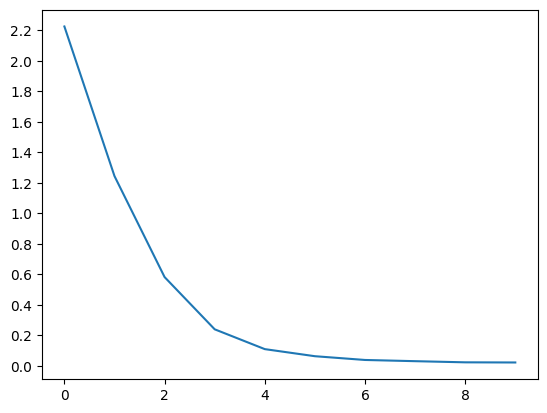

In [101]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

enc = EncoderBiGRU(input_lang.n_words, hidden_size).to(device)
dec = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, enc, dec, 50, print_every=5, plot_every=5)

####Accuracy and Summary

In [102]:
evaluateAccuracy(enc, dec, pairs, input_lang, output_lang)

the number of correct pred is: 1256
the number of wrong is: 314
accuracy: 0.8000


0.8

We can see the new trained model is gain better accuracy of 80% against 70% in the baseline model. The accuracy measure for both is the same and calculated as the number of exact well translated sentences from all sentences.

I made few upgraded to the baseline models that helped to get this result. First, I replaced the encoder with a bidirectional GRU, so each source token representation includes information from both past and future context, which gives the attention mechanism richer features to align with. Second, I increased the model capacity by using two GRU layers (with dropout) in the encoder/decoder, allowing the network to learn more complex sequence patterns while reducing overfitting. Third, I updated the Bahdanau attention to attend over the encoder outputs of size
2
𝐻
2H (due to bidirectionality), improving the quality of the context vector at each decoding step. Finally, I added input-feeding in the decoder (feeding the previous context into the next step) and predicted tokens using both the decoder state and the current context, which stabilizes attention and improves translation consistency—together leading to the 80% accuracy.